<a href="https://colab.research.google.com/github/IVMRanepa/AI-to-help-students-and-teachers/blob/main/okun_law_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследование влияния социальных программ на параметры закона Оукена

**Google Colab Notebook по статье**

**Investigation of the Impact of Social Programs on Okun's Law Parameters in European Countries (Python 3 Analysis)**

## 1. Теоретический обзор

Закон Оукена описывает отрицательную связь между уровнем безработицы и темпами роста ВВП:

**Δu = α - β * ΔY**

где:
- Δu — изменение уровня безработицы
- ΔY — темп роста реального ВВП
- β — коэффициент Оукена

**Гипотеза:** Страны с высокими социальными расходами имеют более НИЗКИЙ коэффициент Оукена.

## 2. Импорт библиотек

In [ ]:
import numpy as np # Импорт библиотеки для работы с числовыми массивами
import pandas as pd # Импорт библиотеки для работы с табличными данными (DataFrame)
import matplotlib.pyplot as plt # Импорт библиотеки для создания статических, анимированных и интерактивных визуализаций
import seaborn as sns # Импорт библиотеки для более привлекательной и информативной графики на основе Matplotlib
from sklearn.linear_model import LinearRegression # Импорт класса для построения модели линейной регрессии
from sklearn.metrics import r2_score, mean_squared_error # Импорт метрик для оценки качества модели (коэффициент детерминации, среднеквадратичная ошибка)
import warnings # Импорт модуля для управления предупреждениями

warnings.filterwarnings('ignore') # Игнорировать все предупреждения, чтобы не засорять вывод

sns.set(style='whitegrid') # Установка стиля графиков Seaborn на 'whitegrid'
plt.rcParams['figure.figsize'] = (12, 6) # Установка стандартного размера для всех графиков Matplotlib

print('Успешный импорт библиотек') # Вывод сообщения об успешном импорте библиотек

Успешный импорт библиотек


## 3. Функция генерации данных

In [ ]:
def generate_okun_data(n_points, beta, intercept, noise_level, mean_gdp=2.0, std_gdp=1.5, random_state=None):
    # Инициализация генератора случайных чисел для воспроизводимости, если random_state задан
    if random_state is not None:
        rng = np.random.default_rng(random_state)
    else:
        rng = np.random.default_rng()

    # Генерация темпов роста ВВП из нормального распределения
    gdp_growth = rng.normal(loc=mean_gdp, scale=std_gdp, size=n_points)
    # Генерация случайного шума (ошибки)
    error = rng.normal(loc=0, scale=noise_level, size=n_points)
    # Расчет изменения уровня безработицы по формуле Закона Оукена с добавлением шума
    unemployment_change = intercept + beta * gdp_growth + error

    # Возвращаем данные в виде DataFrame pandas
    return pd.DataFrame({
        'GDP_Growth': gdp_growth, # Темп роста ВВП
        'Unemp_Change': unemployment_change # Изменение уровня безработицы
    })

print('Функция определена') # Вывод сообщения о том, что функция успешно определена

Функция определена


## 4. Генерация данных

In [ ]:
np.random.seed(42) # Установка начального значения для генератора случайных чисел для воспроизводимости результатов

df_A = generate_okun_data(
    n_points=100, # Количество точек данных для группы A
    beta=-0.15, # Коэффициент Оукена для группы A (низкая чувствительность)
    intercept=0.5, # Свободный член для группы A
    noise_level=0.3, # Уровень шума для группы A
    random_state=1 # Состояние генератора случайных чисел для группы A
)
df_A['Type'] = 'High Social Protection (Rigid)' # Присвоение типа для группы A

df_B = generate_okun_data(
    n_points=100, # Количество точек данных для группы B
    beta=-0.45, # Коэффициент Оукена для группы B (высокая чувствительность)
    intercept=1.0, # Свободный член для группы B
    noise_level=0.4, # Уровень шума для группы B
    random_state=2 # Состояние генератора случайных чисел для группы B
)
df_B['Type'] = 'Low Social Protection (Flexible)' # Присвоение типа для группы B

df = pd.concat([df_A, df_B], ignore_index=True) # Объединение двух DataFrame в один

print('Группа A (жесткий рынок): 100 наблюдений') # Вывод информации о группе A
print('Группа B (гибкий рынок): 100 наблюдений') # Вывод информации о группе B
print(df.head()) # Вывод первых нескольких строк объединенного DataFrame

Группа A (жесткий рынок): 100 наблюдений
Группа B (гибкий рынок): 100 наблюдений
   GDP_Growth  Unemp_Change                            Type
0    2.518376     -0.073141  High Social Protection (Rigid)
1    3.232427      0.273869  High Social Protection (Rigid)
2    2.495656      0.087974  High Social Protection (Rigid)
3    0.045264      0.693956  High Social Protection (Rigid)
4    3.358034      0.361948  High Social Protection (Rigid)


## 5. Регрессионный анализ

In [ ]:
def analyze_okun(data, group_name, verbose=True):
    X = data[['GDP_Growth']] # Выбираем столбец 'GDP_Growth' в качестве независимой переменной
    y = data['Unemp_Change'] # Выбираем столбец 'Unemp_Change' в качестве зависимой переменной

    model = LinearRegression() # Инициализируем модель линейной регрессии
    model.fit(X, y) # Обучаем модель на данных

    beta = model.coef_[0] # Получаем коэффициент Beta (коэффициент Оукена)
    alpha = model.intercept_ # Получаем свободный член (Alpha)
    r2 = r2_score(y, model.predict(X)) # Вычисляем коэффициент детерминации R2
    rmse = np.sqrt(mean_squared_error(y, model.predict(X))) # Вычисляем среднеквадратичную ошибку (RMSE)

    if verbose:
        print(f'\n{group_name}') # Выводим название группы
        print(f'Beta (коэффициент Оукена): {beta:.4f}') # Выводим значение Beta
        print(f'Alpha (свободный член): {alpha:.4f}') # Выводим значение Alpha
        print(f'R2: {r2:.4f}') # Выводим значение R2
        print(f'RMSE: {rmse:.4f}') # Выводим значение RMSE

    return {
        'model': model, # Возвращаем обученную модель
        'beta': beta, # Возвращаем коэффициент Beta
        'alpha': alpha, # Возвращаем свободный член Alpha
        'r2': r2, # Возвращаем R2
        'rmse': rmse, # Возвращаем RMSE
        'name': group_name # Возвращаем название группы
    }

results_A = analyze_okun(df_A, 'High Social Protection') # Анализируем данные для группы A
results_B = analyze_okun(df_B, 'Low Social Protection') # Анализируем данные для группы B


High Social Protection
Beta (коэффициент Оукена): -0.1563
Alpha (свободный член): 0.4898
R2: 0.3105
RMSE: 0.2975

Low Social Protection
Beta (коэффициент Оукена): -0.4207
Alpha (свободный член): 0.9389
R2: 0.7063
RMSE: 0.3871


## 6. Визуализация результатов

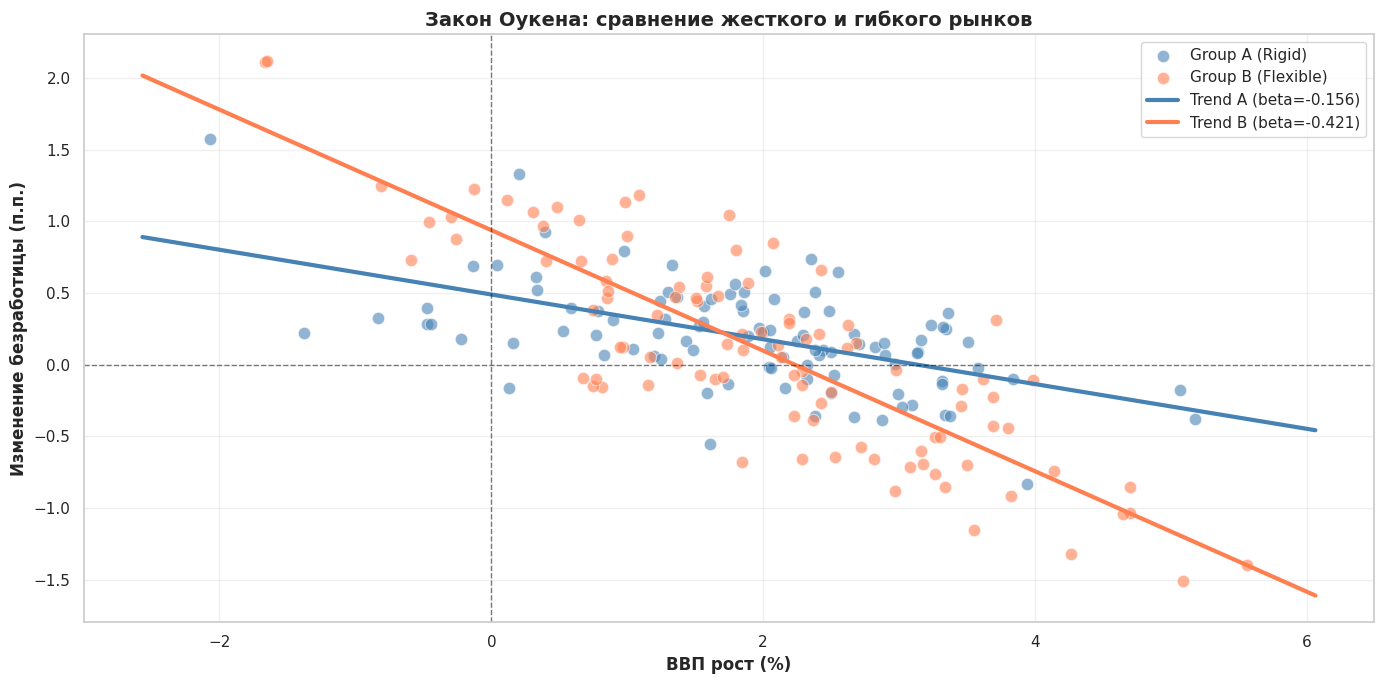

График отрисован


In [ ]:
fig, ax = plt.subplots(figsize=(14, 7)) # Создание фигуры и осей для графика

sns.scatterplot(data=df_A, x='GDP_Growth', y='Unemp_Change',
                color='steelblue', s=80, alpha=0.6, label='Group A (Rigid)', ax=ax) # Точечный график для группы A
sns.scatterplot(data=df_B, x='GDP_Growth', y='Unemp_Change',
                color='coral', s=80, alpha=0.6, label='Group B (Flexible)', ax=ax) # Точечный график для группы B

x_min, x_max = df['GDP_Growth'].min() - 0.5, df['GDP_Growth'].max() + 0.5 # Определение диапазона для оси X
x_range = np.linspace(x_min, x_max, 200).reshape(-1, 1) # Генерация значений для линии тренда

ax.plot(x_range, results_A['model'].predict(x_range), color='steelblue', linewidth=3, label=f"Trend A (beta={results_A['beta']:.3f})") # Построение линии тренда для группы A
ax.plot(x_range, results_B['model'].predict(x_range), color='coral', linewidth=3, label=f"Trend B (beta={results_B['beta']:.3f})") # Построение линии тренда для группы B

ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5) # Горизонтальная линия на уровне Y=0
ax.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5) # Вертикальная линия на уровне X=0

ax.set_xlabel('ВВП рост (%)', fontsize=12, fontweight='bold') # Установка подписи оси X
ax.set_ylabel('Изменение безработицы (п.п.)', fontsize=12, fontweight='bold') # Установка подписи оси Y
ax.set_title('Закон Оукена: сравнение жесткого и гибкого рынков', fontsize=14, fontweight='bold') # Установка заголовка графика
ax.legend(fontsize=11) # Отображение легенды
ax.grid(True, alpha=0.3) # Отображение сетки

plt.tight_layout() # Автоматическая настройка параметров графика для его оптимального размещения____
plt.show() # Отображение графика

print('График отрисован') # Вывод сообщения об отрисовке графика

## 7. Интерпретация результатов

In [ ]:
print('РЕЗУЛЬТАТЫ АНАЛИЗА') # Вывод заголовка раздела с результатами анализа
print('=' * 70) # Вывод разделительной линии
print() # Пустая строка для форматирования
print('ГРУППА A (Жесткий рынок - Социальная Европа):') # Заголовок для группы A
print(f'  Beta: {results_A["beta"]:.4f}') # Вывод значения Beta для группы A
print(f'  Интерпретация: Низкая чувствительность безработицы к ВВП') # Интерпретация Beta для группы A
print(f'  R2: {results_A["r2"]:.4f}') # Вывод значения R2 для группы A
print() # Пустая строка для форматирования
print('ГРУППА B (Гибкий рынок - англо-саксонская модель):') # Заголовок для группы B
print(f'  Beta: {results_B["beta"]:.4f}') # Вывод значения Beta для группы B
print(f'  Интерпретация: Высокая чувствительность безработицы к ВВП') # Интерпретация Beta для группы B
print(f'  R2: {results_B["r2"]:.4f}') # Вывод значения R2 для группы B
print() # Пустая строка для форматирования
print('ВЫВОД:') # Заголовок для выводов
print('Разница в коэффициентах: {:.4f}'.format(abs(results_B['beta']) - abs(results_A['beta']))) # Расчет и вывод разницы коэффициентов Beta
print('Жесткий рынок менее чувствителен в {:.1f}x раз'.format(abs(results_B['beta'])/abs(results_A['beta']))) # Расчет и вывод соотношения чувствительности рынков
print() # Пустая строка для форматирования
print('МЕХАНИЗМ:') # Заголовок для объяснения механизма
print('Группа A: Высокие издержки увольнения -> Labor hoarding -> низкий Beta') # Объяснение механизма для группы A
print('Группа B: Низкие издержки увольнения -> быстрая адаптация -> высокий Beta') # Объяснение механизма для группы B

РЕЗУЛЬТАТЫ АНАЛИЗА

ГРУППА A (Жесткий рынок - Социальная Европа):
  Beta: -0.1563
  Интерпретация: Низкая чувствительность безработицы к ВВП
  R2: 0.3105

ГРУППА B (Гибкий рынок - англо-саксонская модель):
  Beta: -0.4207
  Интерпретация: Высокая чувствительность безработицы к ВВП
  R2: 0.7063

ВЫВОД:
Разница в коэффициентах: 0.2644
Жесткий рынок менее чувствителен в 2.7x раз

МЕХАНИЗМ:
Группа A: Высокие издержки увольнения -> Labor hoarding -> низкий Beta
Группа B: Низкие издержки увольнения -> быстрая адаптация -> высокий Beta


## 8. Для России

In [ ]:
print() # Пустая строка для форматирования
print('ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ ДЛЯ РОССИИ') # Заголовок раздела с рекомендациями
print('=' * 70) # Вывод разделительной линии
print() # Пустая строка для форматирования
print('Российский парадокс рынка труда (Гурвич, 2017):') # Заголовок для российского парадокса
print('  - Россия имеет низкий коэффициент Оукена (~-0.07)') # Описание коэффициента Оукена для России
print('  - НО достигается через гибкость ЗАРПЛАТ, а не пособий') # Описание механизма гибкости
print('  - Это приводит к скрытой безработице') # Последствия механизма
print() # Пустая строка для форматирования
print('Рекомендации:') # Заголовок для рекомендаций
print('  1. Активная политика на рынке труда (переквалификация)') # Первая рекомендация
print('  2. Увеличение пособий по безработице (до 40-50% заработка)') # Вторая рекомендация
print('  3. Региональная дифференциация политики') # Третья рекомендация
print('  4. Автоматизированный мониторинг (Python-аналитика)') # Четвертая рекомендация
print('  5. Переход на скандинавскую модель (баланс + динамика)') # Пятая рекомендация


ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ ДЛЯ РОССИИ

Российский парадокс рынка труда (Гурвич, 2017):
  - Россия имеет низкий коэффициент Оукена (~-0.07)
  - НО достигается через гибкость ЗАРПЛАТ, а не пособий
  - Это приводит к скрытой безработице

Рекомендации:
  1. Активная политика на рынке труда (переквалификация)
  2. Увеличение пособий по безработице (до 40-50% заработка)
  3. Региональная дифференциация политики
  4. Автоматизированный мониторинг (Python-аналитика)
  5. Переход на скандинавскую модель (баланс + динамика)


## 9. Сводная таблица

In [ ]:
summary = pd.DataFrame({ # Создание DataFrame для сводной таблицы
    'Group': ['A: High Social', 'B: Low Social'], # Названия групп
    'Beta': [results_A['beta'], results_B['beta']], # Коэффициенты Beta для групп
    'Alpha': [results_A['alpha'], results_B['alpha']], # Свободные члены Alpha для групп
    'R2': [results_A['r2'], results_B['r2']], # Коэффициенты детерминации R2 для групп
    'RMSE': [results_A['rmse'], results_B['rmse']] # Среднеквадратичные ошибки RMSE для групп
})

print('\nСВОДНАЯ ТАБЛИЦА:') # Вывод заголовка сводной таблицы
print(summary.to_string()) # Вывод сводной таблицы в виде строки


СВОДНАЯ ТАБЛИЦА:
            Group      Beta     Alpha        R2      RMSE
0  A: High Social -0.156284  0.489760  0.310455  0.297509
1   B: Low Social -0.420680  0.938878  0.706276  0.387129


## Используемые источники

1. Anderton R. et al. (2014) - ECB Working Paper Series
2. Ball L., Leigh D., Loungani P. (2017) - Journal of Money, Credit and Banking
3. Гурвич Е. Т. (2017) - Макроэкономические свойства российского рынка труда
4. GitHub: dbnomics/okuns-law-dashboard
5. Kaggle: Okun's Law model

**Версия:** 1.0  
**Совместимость:** Google Colab, Jupyter Notebook, JupyterLab